# Simulators

In [1]:
import random
from dataclasses import dataclass, field
import tempfile
import json
import subprocess
import time
import pandas as pd
from itertools import product
from itertools import combinations_with_replacement

VW_DIR = "../build_release/vowpalwabbit/vw"

@dataclass
class FG:
    numerical: int = 1
    categorical: dict = field(default_factory=lambda: {})  # cardinality -> count

    def generate(self, fname_factor):
        result = {f'n_{i}' * fname_factor : random.random() for i in range(self.numerical)}
        for k, v in self.categorical.items():
            for j in range(v):
                result[f'c_{k}_{j}' * fname_factor] = f'{random.randint(1, k)}'
        return result


def context_gen(shared, multi, slots = None, fname_factor = 1):
    result = {'c': shared.generate(fname_factor), '_multi': [{'a': m.generate(fname_factor)} for m in multi]}

    if slots:
        result['_slots'] = [{'s': s.generate(fname_factor)} for s in slots]
    return result

def generate_cb(context, reward, chosen0, prob):
    a = [(i + 1) for i in range(len(context['_multi']))]
    a[chosen0], a[0] = a[0], a[chosen0]
    p = [prob] #+ [(1 - prob) / (len(a) - 1)] * (len(a) - 1)
    return {
        '_label_cost': -reward,
        '_label_probability': prob,
        '_label_Action': chosen0 + 1,
        '_labelIndex': chosen0,
        'a': a,
        'c': context,
        'p': p 
    }

def generate_ccb(context, rewards, chosens0, probs):
    result = {'c': context, '_outcomes': []}
    chosens = set()
    nactions = len(context['_multi'])
    for r, c, p in zip(rewards, chosens0, probs):
        nactions -= 1
        chosens.add(c)
        result['_outcomes'].append({
            '_label_cost': -r,
            '_a': [c] + list(set(range(len(context['_multi']))) - chosens),
            '_p': [p] + [(1-p) / nactions] * nactions if nactions > 0 else [p]}) 
    
    return result

def ccb_2_ccb1slot(ccb_line):
    o = json.loads(ccb_line)
    c = o['c']
    o['c']['_slots'] = o['c']['_slots'][:1]
    o['_outcomes'] = o['_outcomes'][:1]
    return f'{json.dumps(o, separators=(",", ":"))}\n'

def ccb_2_cb1slot(ccb_line):
    o = json.loads(ccb_line)
    slot0 = o['_outcomes'][0]
    result = {
        '_label_cost': o['_label_cost'],
        '_label_probability': o['_outcomes'][0],
        '_label_Action': chosen0 + 1,
        '_labelIndex': chosen0,
        'a': a,
        'c': context,
        'p': p 
    }
    return f'{json.dumps(result, separators=(",", ":"))}\n'  

def get_string_size_b(s):
    return len(s.encode('utf-8'))

class generator:
    def __init__(self, shared, multi, slots = None, reward_gen = lambda x: 1, chosen0_gen = lambda x: 0, prob_gen = lambda x: 0.5, fname_factor=1):
        self.shared = shared
        self.multi = multi
        self.slots = slots

        self.reward_gen = reward_gen
        self.chosen0_gen = chosen0_gen
        self.prob_gen = prob_gen
        self.fname_factor = fname_factor

    def _generate(self, i):
        context = context_gen(self.shared, self.multi, self.slots, self.fname_factor)
        r = self.reward_gen(i)
        c = self.chosen0_gen(i)
        p = self.prob_gen(i)
        ex = generate_ccb(context, r, c, p) if self.slots else generate_cb(context, r, c, p)
        return f'{json.dumps(ex, separators=(",", ":"))}\n'


    def generate(self, path, count = None, limit_mb = None): 
        with open(path, 'w') as f:
            for i in range(count):
                f.write(self._generate(i))
        f.close()

def run_vw(cmd, filename):
    timeStarted = time.time()
    command = f'{VW_DIR} -d {filename} {cmd}'
    #print(command)
    process = subprocess.Popen(
        command.split(),
        universal_newlines=True,
        encoding='utf-8',
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    error = process.communicate()[1]
    t = time.time() - timeStarted
    metrics = {'average loss': None, 'total feature number': None, 'number of examples': None}
    metrics['t'] = t
    return metrics

def calc_tot_feats(num_continuous, num_cat_low, num_cat_high, actions, slots, quad = True):
    feats = 2**num_continuous + 2**num_cat_low + 2**num_cat_high + 1 # One Extra for default slot feature
    actions = 2**actions
    slots = 2**slots
    if (slots > actions):
        print("Slot count must be less than actions")
    total_feats = 0
    for slot in range(slots):
        if quad:
            standard_ints = len(list(combinations_with_replacement(range(feats),2)))
            total_feats += ((standard_ints+feats)*2 + 1)*actions
        else:
            total_feats += (feats*2 + 1)*actions
        actions -= 1
    return(total_feats)

def calc_tot_feats_cb(num_continuous, num_cat_low, num_cat_high, actions, quad = True):
    feats = 2**num_continuous + 2**num_cat_low + 2**num_cat_high
    actions = 2**actions
    if quad:
        return (feats+len(list(combinations_with_replacement(range(feats),2))))*actions
    else:
        return (feats)*actions

from pathlib import Path
class DsJsonGen:
    def __init__(self, count = 1, folder='data'):
        self.count = count
        self.folder = Path(folder)
        self.folder.mkdir(parents=True, exist_ok=True)

    def gen_file(self, num, cat_low, cat_high, nactions, nslots, fname_factor):
        if (nslots >= 0):
            fname = self.folder.joinpath(f'ccb_{num}_{cat_low}_{cat_high}_{nactions}_{nslots}_{self.count}.json')  
            num = 2**num
            cat_low = 2**cat_low
            cat_high = 2**cat_high
            nactions = 2**nactions
            nslots = 2**nslots
            fname_factor = 2**fname_factor


            shared = FG(numerical = num, categorical = {8: cat_low, 10000000000: cat_high})
            multi = [FG(numerical = 0, categorical = {8: 0, 10000000000: 0})] * nactions
            slots = [FG()] * nslots
            gen = generator(
                shared = shared, 
                multi = multi,
                slots = slots,
                reward_gen = lambda i: [1] * nslots,
                chosen0_gen = lambda i: list(range(nslots)),
                prob_gen = lambda i: [0.5] * nslots,
                fname_factor = fname_factor)
            gen.generate(count = self.count, path=fname)
            return fname, fname.stat().st_size
        else:
            fname = self.folder.joinpath(f'cb_{num}_{cat_low}_{cat_high}_{nactions}_{self.count}.json')  
            num = 2**num
            cat_low = 2**cat_low
            cat_high = 2**cat_high
            nactions = 2**nactions
            fname_factor = 2**fname_factor


            shared = FG(numerical = num, categorical = {8: cat_low, 10000000000: cat_high})
            multi = [FG(numerical = 0, categorical = {8: 0, 10000000000: 0})] * nactions
            gen = generator(
                shared = shared, 
                multi = multi,
                fname_factor = fname_factor)
            gen.generate(count = self.count, path=fname)
            return fname, fname.stat().st_size

def get_feat_per_sec(num_continuous = 0, num_cat_low = 0, num_cat_high = 0, num_actions = 0, num_slots = 0, example_count = 10**3, quad = True, cache = True, no_pred = True):
    grid = pd.DataFrame(product([num_continuous], [num_cat_low], [num_cat_high], [num_actions], [num_slots], [0]), columns = ['num', 'cat_low', 'cat_high', 'nactions', 'nslots', 'fname_factor'])
    evaluator = DsJsonGen(example_count)
    result = []
    for x in grid.to_dict('records'):
        fname, fsize = evaluator.gen_file(**x)
        if (num_slots) >= 0:
            cmd = '--ccb_explore_adf --dsjson --noconstant'
            if quad:
                cmd += ' -q ::'
            if cache:
                cmd += ' -c'
            if no_pred:
                cmd += ' --no_predict'
            metrics = run_vw(cmd, fname)
            metrics["total feature number"] = example_count * calc_tot_feats(num_continuous, num_cat_low, num_cat_high, num_actions,num_slots, quad)
        else:
            cmd = '--cb_explore_adf --dsjson --noconstant'
            if quad:
                cmd += ' -q ::'
            if cache:
                cmd += ' -c'
            if no_pred:
                cmd += ' --no_predict'
            metrics = run_vw(cmd, fname)
            metrics["total feature number"] = example_count * calc_tot_feats_cb(num_continuous, num_cat_low, num_cat_high, num_actions, quad)
        metrics['fsize'] = fsize
        result.append(dict(x, **metrics))
    return result[0]['total feature number'], result[0]['t'], result[0]['fsize']

### Investigate how number of examples effects feat/sec

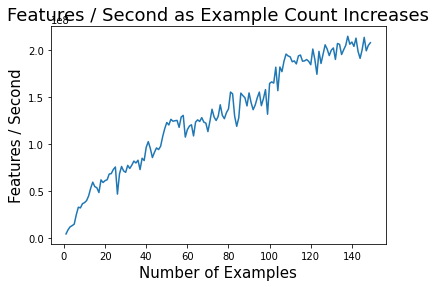

In [2]:
import matplotlib.pyplot as plt
num_ex = 150
example_diffs = []
scale = 1
for ex in range(1,num_ex):
    example_diffs.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, -1, ex*scale)))

plt.plot([ex[0] for ex in example_diffs], [ex[1][0] / ex[1][1] for ex in example_diffs])
plt.title("Features / Second as Example Count Increases", size=18)
plt.xlabel("Number of Examples", size=15)
plt.ylabel("Features / Second", size=15)
plt.show()

In [8]:
## WITH CACHE
### CB
import matplotlib.pyplot as plt
start_ex = 1
num_ex = 30
cb_example_diffs_quad_cache = []
scale = 8
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"cb_quad_cache")
    get_feat_per_sec(5, 5, 5, 6, -1, ex*scale, quad=True, cache=True)
    cb_example_diffs_quad_cache.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, -1, ex*scale, quad=True, cache=True)))

cb_example_diffs_single_cache = []
scale = 400
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"cb_cache")
    get_feat_per_sec(5, 5, 5, 6, -1, ex*scale, quad=False, cache=True)
    cb_example_diffs_single_cache.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, -1, ex*scale, quad=False, cache=True)))

### CCB
ccb_example_diffs_quad_cache = []
scale = 1
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"ccb_quad_cache")
    get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=True, cache=True)
    ccb_example_diffs_quad_cache.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=True, cache=True)))

ccb_example_diffs_single_cache = []
scale = 50
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"ccb_cache")
    get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=False, cache=True)
    ccb_example_diffs_single_cache.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=False, cache=True)))

## WITHOUT CACHE
cb_example_diffs_quad = []
scale = 8
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"cb_quad")
    cb_example_diffs_quad.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, -1, ex*scale, quad=True, cache=False)))

cb_example_diffs_single = []
scale = 400
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"cb")
    cb_example_diffs_single.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, -1, ex*scale, quad=False, cache=False)))

### CCB
ccb_example_diffs_quad = []
scale = 1
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"ccb_quad")
    ccb_example_diffs_quad.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=True, cache=False)))

ccb_example_diffs_single = []
scale = 50
for ex in range(start_ex, start_ex + num_ex, 2):
    print(ex,"ccb")
    ccb_example_diffs_single.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=False, cache=False)))

1 cb_quad_cache
3 cb_quad_cache
5 cb_quad_cache
7 cb_quad_cache
9 cb_quad_cache
11 cb_quad_cache
13 cb_quad_cache
15 cb_quad_cache
17 cb_quad_cache
19 cb_quad_cache
21 cb_quad_cache
23 cb_quad_cache
25 cb_quad_cache
27 cb_quad_cache
29 cb_quad_cache
1 cb_cache
3 cb_cache
5 cb_cache
7 cb_cache
9 cb_cache
11 cb_cache
13 cb_cache
15 cb_cache
17 cb_cache
19 cb_cache
21 cb_cache
23 cb_cache
25 cb_cache
27 cb_cache
29 cb_cache
1 ccb_quad_cache
3 ccb_quad_cache
5 ccb_quad_cache
7 ccb_quad_cache
9 ccb_quad_cache
11 ccb_quad_cache
13 ccb_quad_cache
15 ccb_quad_cache
17 ccb_quad_cache
19 ccb_quad_cache
21 ccb_quad_cache
23 ccb_quad_cache
25 ccb_quad_cache
27 ccb_quad_cache
29 ccb_quad_cache
1 ccb_cache
3 ccb_cache
5 ccb_cache
7 ccb_cache
9 ccb_cache
11 ccb_cache
13 ccb_cache
15 ccb_cache
17 ccb_cache
19 ccb_cache
21 ccb_cache
23 ccb_cache
25 ccb_cache
27 ccb_cache
29 ccb_cache
1 cb_quad
3 cb_quad
5 cb_quad
7 cb_quad
9 cb_quad
11 cb_quad
13 cb_quad
15 cb_quad
17 cb_quad
19 cb_quad
21 cb_quad
23 c

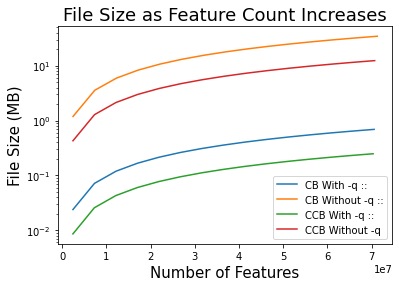

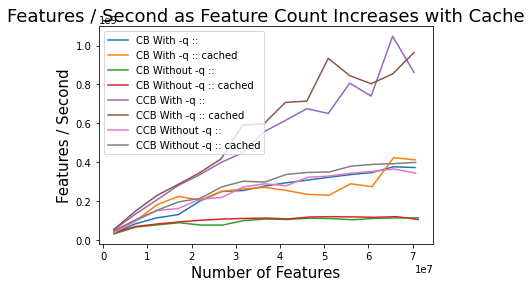

In [9]:
plt.plot([ex[1][0] for ex in cb_example_diffs_quad], [ex[1][2] / 1024**2 for ex in cb_example_diffs_quad])
plt.plot([ex[1][0] for ex in cb_example_diffs_single], [ex[1][2] / 1024**2 for ex in cb_example_diffs_single])
plt.plot([ex[1][0] for ex in ccb_example_diffs_quad], [ex[1][2] / 1024**2 for ex in ccb_example_diffs_quad])
plt.plot([ex[1][0] for ex in ccb_example_diffs_single], [ex[1][2] / 1024**2 for ex in ccb_example_diffs_single])


plt.legend(["CB With -q ::", "CB Without -q ::", "CCB With -q ::", "CCB Without -q"])
plt.title("File Size as Feature Count Increases", size=18)
plt.xlabel("Number of Features", size=15)
plt.ylabel("File Size (MB)", size=15)
plt.yscale('log')
plt.show()

plt.plot([ex[1][0] for ex in cb_example_diffs_quad], [ex[1][0] / ex[1][1] for ex in cb_example_diffs_quad])
plt.plot([ex[1][0] for ex in cb_example_diffs_quad_cache], [ex[1][0] / ex[1][1] for ex in cb_example_diffs_quad_cache])
plt.plot([ex[1][0] for ex in cb_example_diffs_single], [ex[1][0] / ex[1][1] for ex in cb_example_diffs_single])
plt.plot([ex[1][0] for ex in cb_example_diffs_single_cache], [ex[1][0] / ex[1][1] for ex in cb_example_diffs_single_cache])
plt.plot([ex[1][0] for ex in ccb_example_diffs_quad], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_quad])
plt.plot([ex[1][0] for ex in ccb_example_diffs_quad_cache], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_quad_cache])
plt.plot([ex[1][0] for ex in ccb_example_diffs_single], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_single])
plt.plot([ex[1][0] for ex in ccb_example_diffs_single_cache], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_single_cache])

plt.legend(["CB With -q ::", "CB With -q :: cached", "CB Without -q ::", "CB Without -q :: cached", "CCB With -q ::", "CCB With -q :: cached", "CCB Without -q ::", "CCB Without -q :: cached"])
plt.title("Features / Second as Feature Count Increases with Cache", size=18)
plt.xlabel("Number of Features", size=15)
plt.ylabel("Features / Second", size=15)
plt.show()

In [5]:
start_ex = 1
num_ex = 200

### NO PREDICTIONS
ccb_example_diffs_quad_no_pred = []
scale = 1
for ex in range(start_ex, start_ex + num_ex, 5):
    print(ex,"ccb_quad_no_pred")
    ccb_example_diffs_quad_no_pred.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=True, no_pred=True)))

ccb_example_diffs_no_pred = []
scale = 50
for ex in range(start_ex, start_ex + num_ex, 5):
    print(ex,"ccb_no_pred")
    ccb_example_diffs_no_pred.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=False, no_pred=True)))

### WITH PREDICTIONS
ccb_example_diffs_quad = []
scale = 1
for ex in range(start_ex, start_ex + num_ex, 5):
    print(ex,"ccb_quad")
    ccb_example_diffs_quad.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=True, no_pred=False)))

ccb_example_diffs = []
scale = 50
for ex in range(start_ex, start_ex + num_ex, 5):
    print(ex,"ccb")
    ccb_example_diffs.append((ex*scale, get_feat_per_sec(5, 5, 5, 6, 2, ex*scale, quad=False, no_pred=False)))

1 ccb_quad_no_pred
6 ccb_quad_no_pred
11 ccb_quad_no_pred
16 ccb_quad_no_pred
21 ccb_quad_no_pred
26 ccb_quad_no_pred
31 ccb_quad_no_pred
36 ccb_quad_no_pred
41 ccb_quad_no_pred
46 ccb_quad_no_pred
51 ccb_quad_no_pred
56 ccb_quad_no_pred
61 ccb_quad_no_pred
66 ccb_quad_no_pred
71 ccb_quad_no_pred
76 ccb_quad_no_pred
81 ccb_quad_no_pred
86 ccb_quad_no_pred
91 ccb_quad_no_pred
96 ccb_quad_no_pred
101 ccb_quad_no_pred
106 ccb_quad_no_pred
111 ccb_quad_no_pred
116 ccb_quad_no_pred
121 ccb_quad_no_pred
126 ccb_quad_no_pred
131 ccb_quad_no_pred
136 ccb_quad_no_pred
141 ccb_quad_no_pred
146 ccb_quad_no_pred
151 ccb_quad_no_pred
156 ccb_quad_no_pred
161 ccb_quad_no_pred
166 ccb_quad_no_pred
171 ccb_quad_no_pred
176 ccb_quad_no_pred
181 ccb_quad_no_pred
186 ccb_quad_no_pred
191 ccb_quad_no_pred
196 ccb_quad_no_pred
1 ccb_no_pred
6 ccb_no_pred
11 ccb_no_pred
16 ccb_no_pred
21 ccb_no_pred
26 ccb_no_pred
31 ccb_no_pred
36 ccb_no_pred
41 ccb_no_pred
46 ccb_no_pred
51 ccb_no_pred
56 ccb_no_pred
61 c

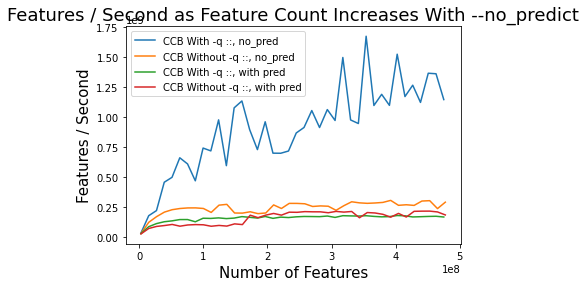

In [6]:
plt.plot([ex[1][0] for ex in ccb_example_diffs_quad_no_pred], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_quad_no_pred])
plt.plot([ex[1][0] for ex in ccb_example_diffs_no_pred], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_no_pred])
plt.plot([ex[1][0] for ex in ccb_example_diffs_quad], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_quad])
plt.plot([ex[1][0] for ex in ccb_example_diffs], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs])

plt.legend(["CCB With -q ::, no_pred", "CCB Without -q ::, no_pred", "CCB With -q ::, with pred", "CCB Without -q ::, with pred"])
plt.title("Features / Second as Feature Count Increases With --no_predict", size=18)
plt.xlabel("Number of Features", size=15)
plt.ylabel("Features / Second", size=15)

#plt.yscale('log')
plt.show()

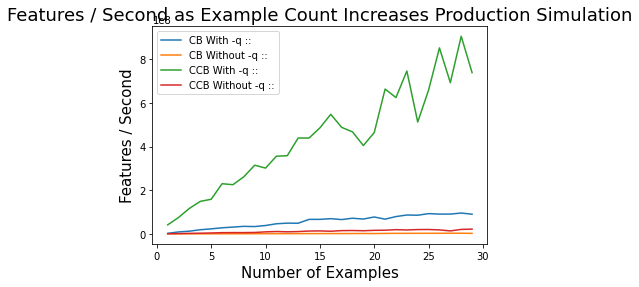

In [7]:
### CB
import matplotlib.pyplot as plt
num_ex = 30
cb_example_diffs_quad = []
for ex in range(1,num_ex):
    cb_example_diffs_quad.append((ex, get_feat_per_sec(5, 5, 5, 6, -1, ex, quad=True)))

cb_example_diffs_single = []
for ex in range(1,num_ex):
    cb_example_diffs_single.append((ex, get_feat_per_sec(5, 5, 5, 6, -1, ex, quad=False)))

### CCB
ccb_example_diffs_quad = []
for ex in range(1,num_ex):
    ccb_example_diffs_quad.append((ex, get_feat_per_sec(5, 5, 5, 6, 2, ex, quad=True)))

ccb_example_diffs_single = []
for ex in range(1,num_ex):
    ccb_example_diffs_single.append((ex, get_feat_per_sec(5, 5, 5, 6, 2, ex, quad=False)))
    
plt.plot([ex[0] for ex in cb_example_diffs_quad], [ex[1][0] / ex[1][1] for ex in cb_example_diffs_quad])
plt.plot([ex[0] for ex in cb_example_diffs_single], [ex[1][0] / ex[1][1] for ex in cb_example_diffs_single])
plt.plot([ex[0] for ex in ccb_example_diffs_quad], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_quad])
plt.plot([ex[0] for ex in ccb_example_diffs_single], [ex[1][0] / ex[1][1] for ex in ccb_example_diffs_single])
plt.legend(["CB With -q ::", "CB Without -q ::", "CCB With -q ::", "CCB Without -q ::"])
plt.title("Features / Second as Example Count Increases Production Simulation", size=18)
plt.xlabel("Number of Examples", size=15)
plt.ylabel("Features / Second", size=15)
plt.show()